In [ ]:
#loading the libraries
from tensorflow.keras.layers import concatenate
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, Flatten,Conv2D, Dense,BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
#loading the directories
main_dir = "/content/drive/MyDrive/chest_xray/chest_xray"
train_data_dir = main_dir + "/train"
validation_data_dir = main_dir + "/val"
test_data_dir = main_dir + "/test"
train_n = train_data_dir+'/NORMAL'
train_p = train_data_dir+'/PNEUMONIA'

In [ ]:
#data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
img_width , img_height = [224,224]
batch_size = 16
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)
validation_generator = val_datagen.flow_from_directory(
validation_data_dir,
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='binary')

test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


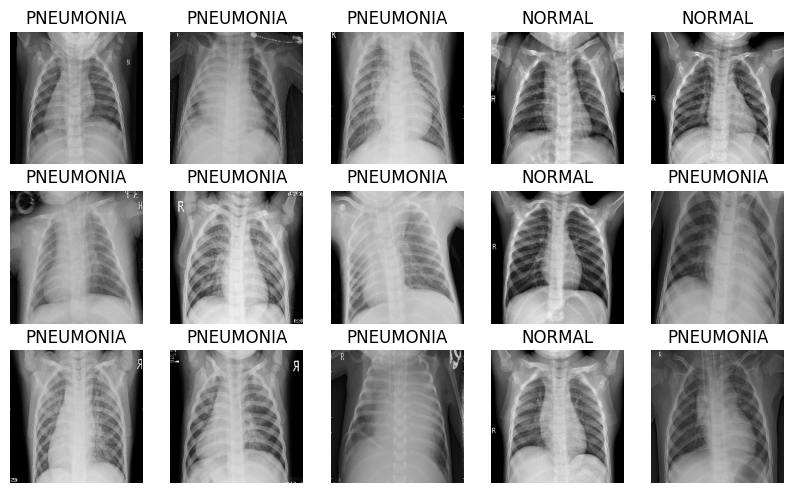

In [ ]:
#This code snippet is useful for visualizing a batch of images along with their labels to get a quick look at the data
#and verify that the data loading and preprocessing are working as expected.
import matplotlib.pyplot as plt
image_batch, label_batch = next(iter(train_generator))
def show_batch(image_batch, label_batch):
      plt.figure(figsize=(10, 10))
      for n in range(15):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
           plt.title("PNEUMONIA")
        else:
           plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch, label_batch)

In [ ]:
#using pre-trained model
import tensorflow as tf
input_shape = (224,224,3)
input_layer = Input(shape = (224, 224, 3))
#first model
mobilenet_base = MobileNetV2(weights = 'imagenet',input_shape = input_shape,include_top = False)

densenet_base = DenseNet169(weights = 'imagenet', input_shape = input_shape,include_top = False)
for layer in mobilenet_base.layers:
    layer.trainable =  False
for layer in densenet_base.layers:
    layer.trainable = False

model_mobilenet = mobilenet_base(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)
model_densenet = densenet_base(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

merged = tf.keras.layers.Concatenate()([output_mobilenet, output_densenet])

x = BatchNormalization()(merged)
x = Dense(256,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)
stacked_model = tf.keras.models.Model(inputs = input_layer, outputs = x)



In [ ]:
stacked_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_4[0][0]']             
 tional)                                                                                          
                                                                                                  
 densenet169 (Functional)    (None, 7, 7, 1664)           1264288   ['input_4[0][0]']             
                                                          0                                       
                                                                                            

In [ ]:
#compiling the model
optm = Adam(learning_rate=0.0001)
stacked_model.compile(loss='binary_crossentropy', optimizer=optm,
                  metrics=['accuracy'])

In [ ]:
#defining early stopping
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
EarlyStopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=.01,
                              patience=6,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)
rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=6,
                            verbose=0,
                            mode="max",
                            min_delta=0.01)
model_save = ModelCheckpoint('./stacked_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose = 1)


In [ ]:
#defining no of epochs
nb_train_samples = 5216 # number of training-samples
nb_validation_samples = 16 # number of validation-samples
nb_test_samples = 624 # number of training-samples
epochs = 20
batch_size  = 16

In [ ]:
stacked_history = stacked_model.fit(train_generator,
                              steps_per_epoch = nb_train_samples // batch_size,
                              epochs = 20,
                              validation_data = test_generator,

                              callbacks=[EarlyStopping, model_save,rlr])

Epoch 1/20
326/326 [==============================] - ETA: 0s - loss: 0.3819 - accuracy: 0.8230
Epoch 1: val_loss improved from inf to 0.31403, saving model to ./stacked_model.h5
326/326 [==============================] - 1539s 5s/step - loss: 0.3819 - accuracy: 0.8230 - val_loss: 0.3140 - val_accuracy: 0.8590 - lr: 1.0000e-04
Epoch 2/20
326/326 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9239
Epoch 2: val_loss did not improve from 0.31403
326/326 [==============================] - 1555s 5s/step - loss: 0.2017 - accuracy: 0.9239 - val_loss: 0.3406 - val_accuracy: 0.8590 - lr: 1.0000e-04
Epoch 3/20
326/326 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9413
Epoch 3: val_loss did not improve from 0.31403
326/326 [==============================] - 1478s 5s/step - loss: 0.1582 - accuracy: 0.9413 - val_loss: 0.3908 - val_accuracy: 0.8558 - lr: 1.0000e-04
Epoch 4/20
326/326 [==============================] - ETA: 0s - loss: 0.1268 - accura

In [ ]:
# def process_image(image):
#     image = image/255
#     image = cv2.resize(image, (224,224))
#     return image

def process_image(image):
    try:
        # Check if image is None
        if image is None:
            raise ValueError("Image is None")

        # Normalize and resize the image
        image = image / 255
        image = cv2.resize(image, (224, 224))
        return image
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

In [ ]:
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)

    ps = model.predict(processed_test_image)
    return ps

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import numpy as np
import seaborn as sb
def testing(model, test_df):
    base_pred = []
    for image in test_df.img_path:
        base_pred.append(predict(image, model)[0][0])

    final_base_pred = np.where(np.array(base_pred) > 0.5, 1, 0)
    actual_label = test_df['label']
    unique_labels = set(actual_label)
    print("Unique Labels:", unique_labels)
    # print(classification_report(actual_label, final_base_pred))
    if len(set(actual_label)) > 1:
     print(classification_report(actual_label, final_base_pred))
     matrix = confusion_matrix(actual_label, final_base_pred)
     sb.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False,
               xticklabels=['0', '1'],
               yticklabels=['0', '1'])
     plt.xlabel('Predicted label')
     plt.ylabel('True label')

    else:
     print("Insufficient labels for classification report.")




In [ ]:
def extract_label_from_filename(filename):
    # Assuming filenames are formatted like "/path/to/data/class/filename.jpg"
    # Extract the class label by splitting the filename
    label = os.path.basename(os.path.dirname(filename))
    return 0 if label.lower() == 'normal' else 1



In [ ]:
import os
import cv2
import pandas as pd

# Path to the test data folder
test_data_folder = '/content/drive/MyDrive/chest_xray/chest_xray/test'

# List to store file paths and labels
file_paths = []
labels = []

# Iterate over subfolders in the test data folder
for label in os.listdir(test_data_folder):
    label_folder = os.path.join(test_data_folder, label)

    # Check if it's a directory
    if os.path.isdir(label_folder):
        # Iterate over images in the label subfolder
        for filename in os.listdir(label_folder):
            file_path = os.path.join(label_folder, filename)

            # Check if it's a file and ends with a valid image extension
            if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Assuming you can extract the label from the subfolder name
                labels.append(label)
                file_paths.append(file_path)

# Create a DataFrame
test_df = pd.DataFrame({'img_path': file_paths, 'label': labels})

In [ ]:
# Convert string labels to integers
label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}
test_df['label'] = test_df['label'].map(label_mapping)

# Now, test_df['label'] contains integer labels


1/1 [==============================] - 0s 247ms/step
Unique Labels: {0, 1}
              precision    recall  f1-score   support

           0       0.95      0.65      0.77       234
           1       0.82      0.98      0.89       390

    accuracy                           0.86       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.86      0.85       624



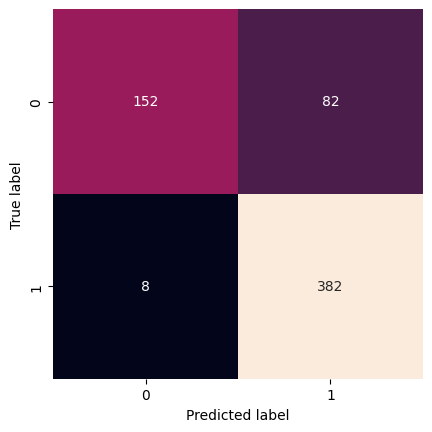

In [ ]:
testing(stacked_model,test_df)

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

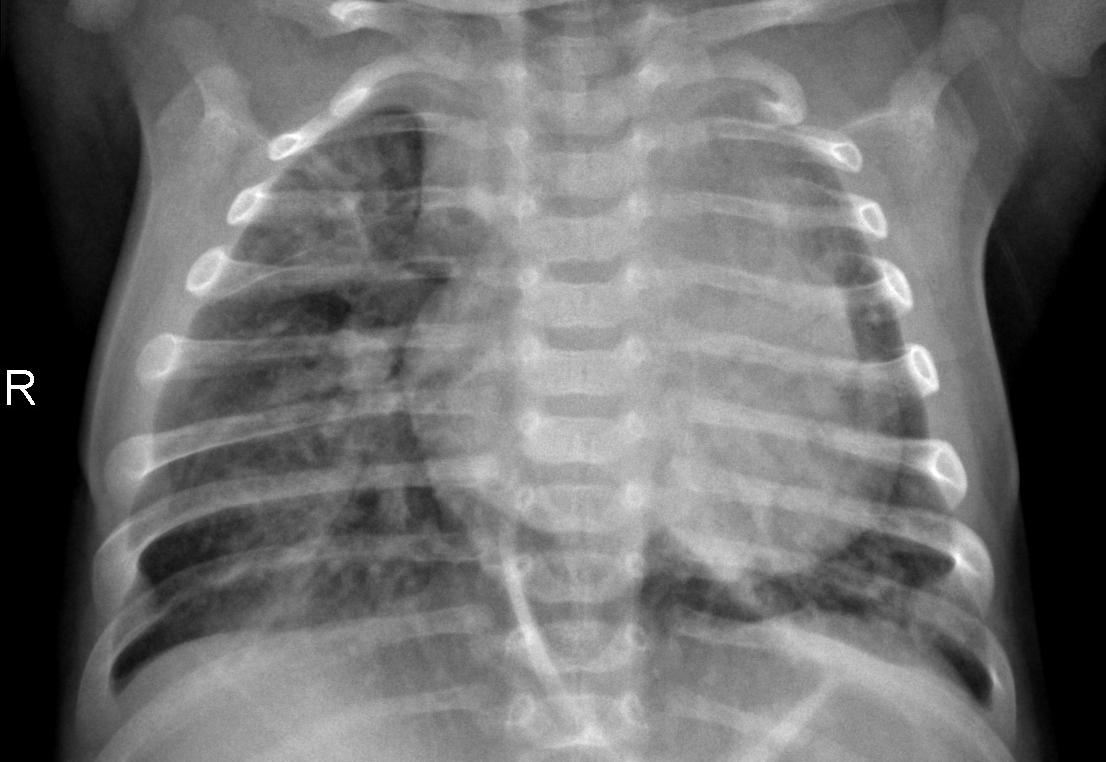

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

img_path = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

91884032/91884032 [==============================] - 1s 0us/step


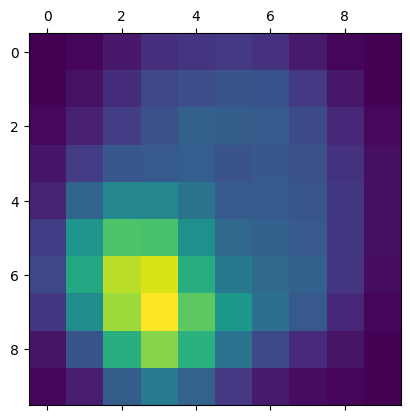

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

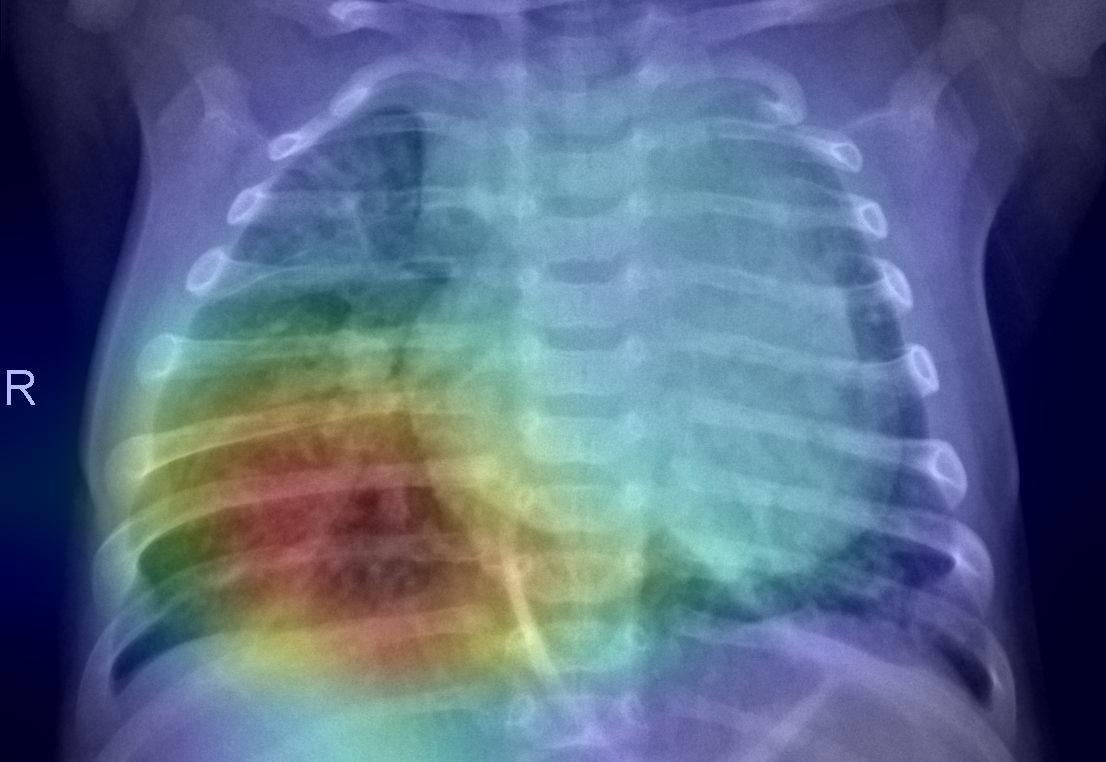

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

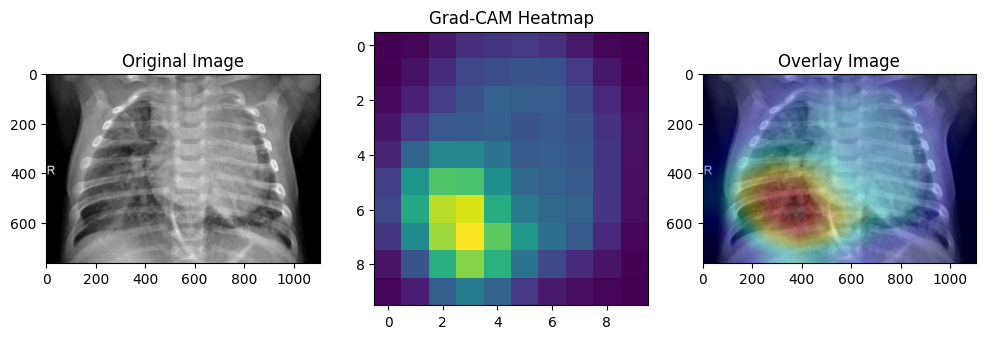

In [ ]:

import matplotlib.pyplot as plt
import cv2

def overlay_heatmap_on_image(original_image, heatmap):
    # Rescale heatmap to the same dimensions as the original image
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Convert heatmap to a color map for visualization
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Blend the heatmap with the original image
    overlay_image = cv2.addWeighted(original_image, 0.7, heatmap_color, 0.3, 0)

    return overlay_image

# Example usage
original_image = cv2.imread('/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')  # Replace with the path to your image
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Overlay heatmap on the original image
overlay_image = overlay_heatmap_on_image(original_image, heatmap)

# Display the original image, heatmap, and overlay
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(original_image[:, :, ::-1])  # Convert BGR to RGB for display
plt.title('Original Image')

plt.subplot(132)
plt.imshow(heatmap, cmap='viridis')
plt.title('Grad-CAM Heatmap')

plt.subplot(133)
plt.imshow(overlay_image[:, :, ::-1])  # Convert BGR to RGB for display
plt.title('Overlay Image')
plt.show()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def annotate_image(image_path):
    # Load the chest X-ray image
    image = cv2.imread(image_path)

    # Create a binary mask for pneumonia manually (for example, by drawing on the image)
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)

    # Display the image and allow annotation
    cv2_imshow(image)
    cv2_imshow( mask)

    # Allow the user to draw on the image and create the binary mask
    mask = cv2.drawContours(mask, [np.array([[100, 100], [200, 100], [200, 200], [100, 200]])], -1, (255), thickness=cv2.FILLED)

    cv2_imshow( mask)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return mask

# Example usage
image_path = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
ground_truth_mask = annotate_image(image_path)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Assuming you have ground truth binary mask and predicted binary mask
# ground_truth_mask = ...
# binary_heatmap = ...
heatmap_resized = cv2.resize(heatmap, (ground_truth_mask.shape[1], ground_truth_mask.shape[0]))
# Threshold the resized heatmap to create a binary mask
binary_heatmap = (heatmap_resized > 0.5).astype(np.uint8)
# Flatten the masks for metrics calculation

ground_truth_flat = ground_truth_mask.flatten()
predicted_flat = binary_heatmap.flatten()

# Calculate metrics
precision = precision_score(ground_truth_flat, predicted_flat, average='weighted')  # or 'macro', 'weighted', 'samples'
recall = recall_score(ground_truth_flat, predicted_flat, average='weighted')  # or 'macro', 'weighted', 'samples'
f1 = f1_score(ground_truth_flat, predicted_flat, average='weighted')  # or 'macro', 'weighted', 'samples'
accuracy = accuracy_score(ground_truth_flat, predicted_flat)
roc_auc = roc_auc_score(ground_truth_flat, predicted_flat, average='weighted')  # or 'macro', 'weighted'

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)
print("AUC-ROC:", roc_auc)